In [1]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve


In [2]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']

training_path    = '../../../../dataset/audios/training'
original_path    = os.path.join(training_path, 'original')
processed_path   = os.path.join(training_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

In [3]:
original = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(original_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        original[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [4]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(processed_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        processed[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [5]:
FRAME_SIZE = 512 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

In [6]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [7]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [7]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

In [8]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

In [ ]:
cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        #spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #BER  = band_energy_ratio(spec, split_frequency, sr)
        #BER /= np.max(BER)
        #feat = np.mean(BER)

        #centroidal = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #centroidal /= np.max(centroidal)
        #centroidal = np.mean(centroidal)
        #smoothed = rms(signal)
        #smoothed = smoothed.reshape(-1,)
        #rms_smoothed = np.mean(smoothed)/np.max(smoothed)
        #filtered = low_pass_filter(signal, sr, cutoff)
        #feat = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #max = np.max(zcr)
        #flux = spectral_flux(filtered)
        #max = np.max(flux)
        #flux /= max
        #flux = np.mean(flux)
        #roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.85)[0]
        #max = np.max(roll_off)
        #roll_off /= max
        #roll_off = np.mean(roll_off)
        #smoothed /= np.max(smoothed)
        #N = 1
        #feat = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 5, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #feat = librosa.feature.delta(feat, order = 3)

        #frames = range(len(feat))
        #t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)

        #absolute = np.abs(feat)
        #feat /= np.max(absolute)
        #absolute /= np.max(absolute)
        #feat = np.abs(feat)
        #row = feat[N,:]
        #row = np.abs(row)

        #momentum = np.dot(t, absolute)
        #momentum/=np.sum(absolute)
        #means = np.mean(feat)

        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)




**MFCC**

- Media.
Tomando la media alrededor de los 2/3 con 5 de cada lado con 512 de frames se consigue la separación de las naranjas respecto de lo demás en la componente 1

C:\Users\Juan\AppData\Local\Temp\ipykernel_4356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


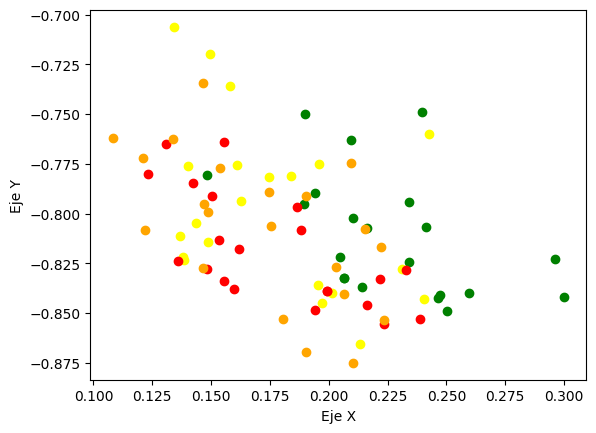

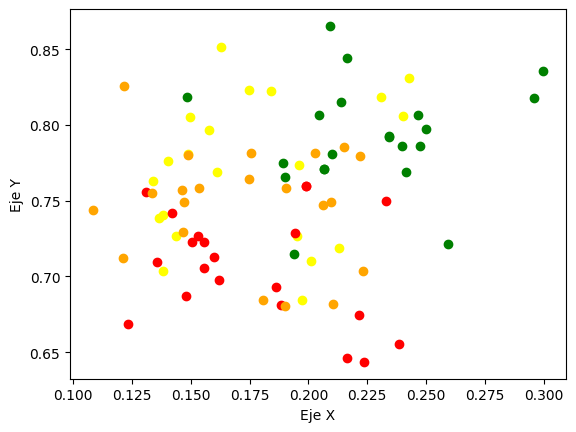

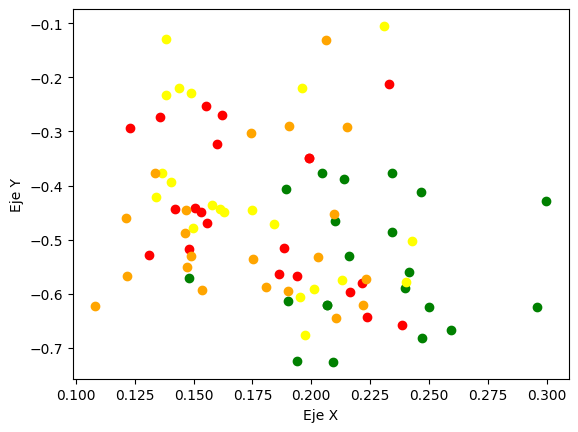

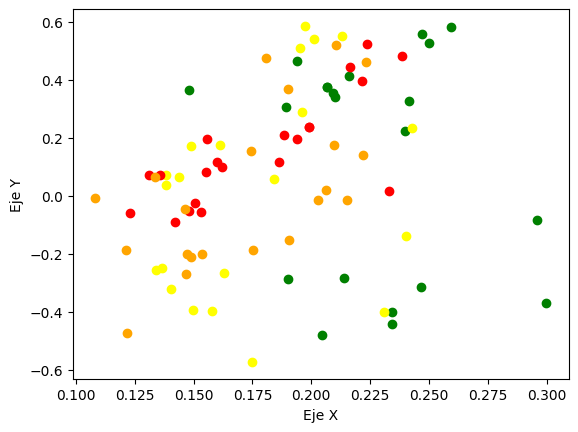

In [19]:
cutoff = 8500
cuton = 50
features = dict.fromkeys(fruit_types)
n_mfcc = 4
componente = 0

# Extracción de características
while componente < n_mfcc:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

            signal = band_pass_filter(signal, sr, cuton, cutoff)
            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            #feat = np.mean(mfccs[:, ((mfccs.shape[1]*2)//3 - 8) : ((mfccs.shape[1]*2)//3 + 8)], axis = 1)
            feat = np.mean(mfccs, axis = 1)
            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    componente += 1


- RMS. Mejor la media que el RMS

In [ ]:
cutoff = 6500
cuton = 50
features = dict.fromkeys(fruit_types)
split_frequency = 200


# Extracción de características
componnte = 0
while componente < 30:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 30, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            feat = np.sqrt(np.mean(mfccs**2, axis=1))


            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    input()
    componente += 1


- Máximo. En la componente 3 se separan las manzanas de las peras. En la componente 3 en el 2/5 separa una banda las naranjas de als manzanas. Con el filtro como está ahora configurado, puede que funcione igual o mejor de bien cuando se calcula a lo largo de toda la duración del audio

C:\Users\Juan\AppData\Local\Temp\ipykernel_6348\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)
c:\Users\Juan\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
C:\Users\Juan\AppData\Local\Temp\ipykernel_6348\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


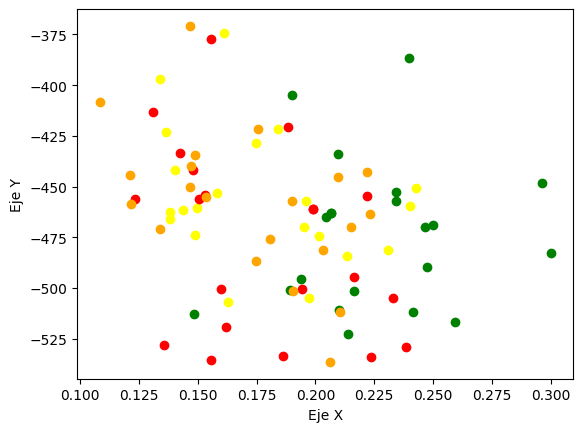

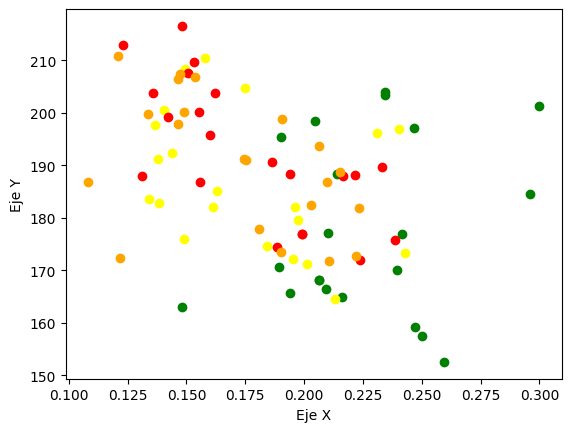

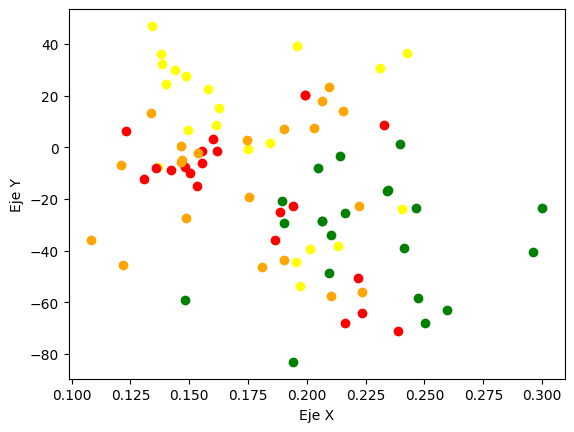

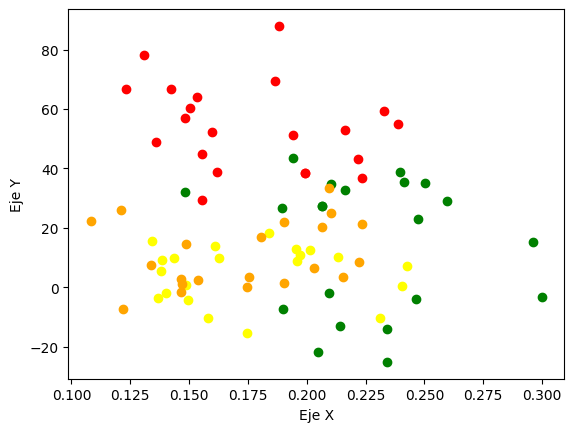

In [9]:
cutoff = 5000
cuton = 500
features = dict.fromkeys(fruit_types)
n_mfcc = 4

# Extracción de características
componente = 0
while componente < n_mfcc:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

            signal = band_pass_filter(signal, sr, cuton, cutoff)

            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            #feat = np.max(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
            feat = np.max(mfccs, axis = 1)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    componente += 1


- Desviación estándar. Lo mismo que la varianza respecto de la componente 1. Separa a las manzanas de las peras y las naranjas y las bananas quedan en el medio medio solapadas. Con un filtro de pasa banda con cortes en 10 y en 8500 y un frame de 512

C:\Users\Juan\AppData\Local\Temp\ipykernel_6348\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


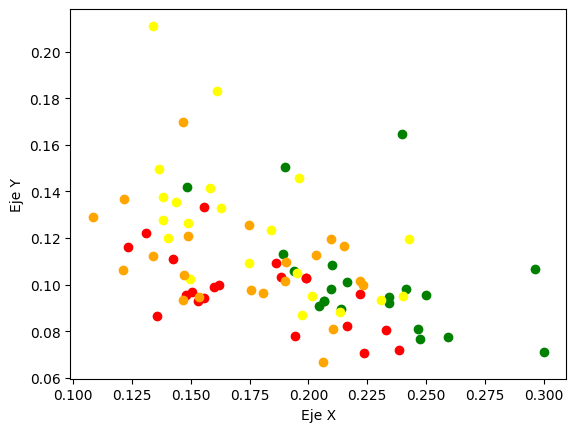

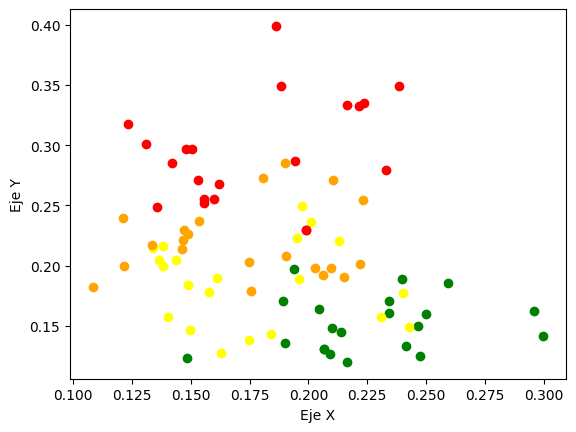

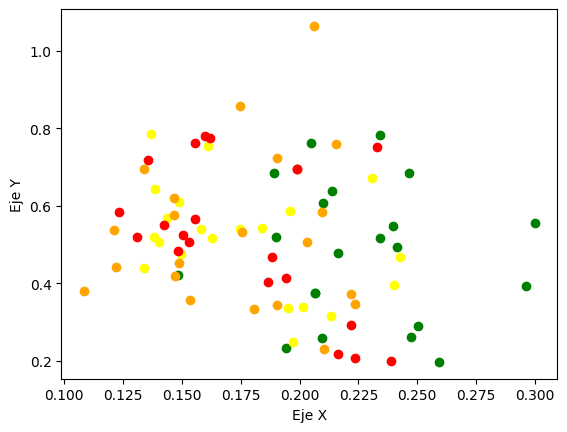

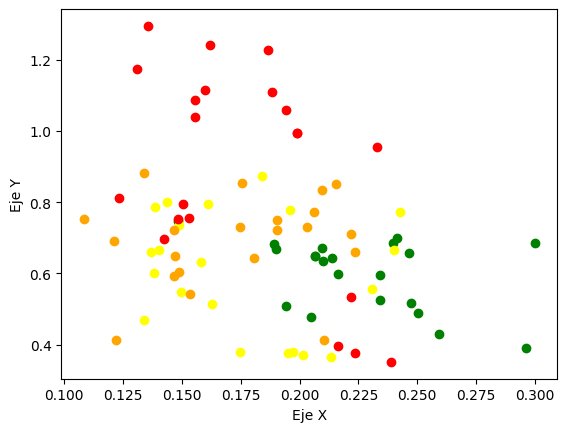

In [10]:
cutoff = 8000
cuton = 10
features = dict.fromkeys(fruit_types)

# Extracción de características
n_mfcc = 4
componente = 0
while componente < n_mfcc:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

            signal = band_pass_filter(signal, sr, cuton, cutoff)
            
            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            #feat = np.std(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)/np.mean(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
            feat = np.std(np.abs(mfccs), axis = 1)/np.mean(np.abs(mfccs), axis = 1)
            
            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    
    componente += 1


- Con el momento con suma. Buena separación de las peras respecto de las demas con la componente 0. En todas las componentes en realidad. Lo que pasa es que, como ya dijimos, las peras tienen en promedio una duración menor y eso es lo que se ve reflejado en los momentos

C:\Users\Juan\AppData\Local\Temp\ipykernel_4356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


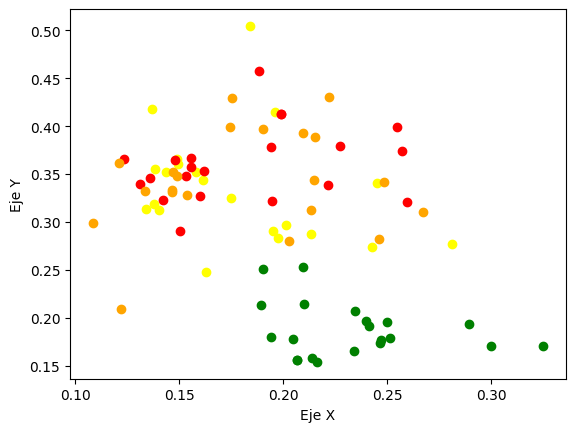

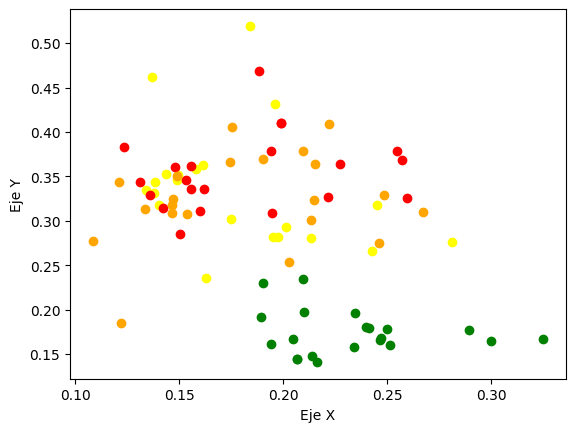

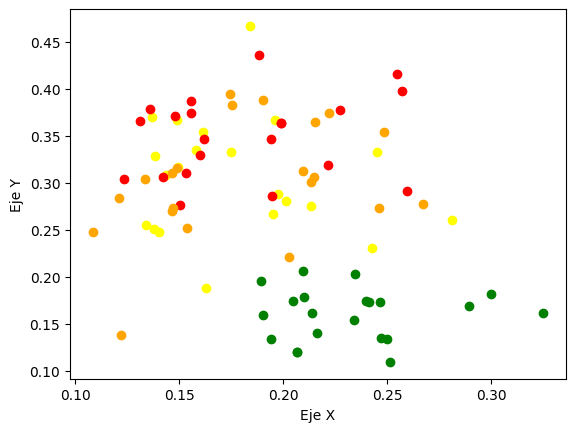

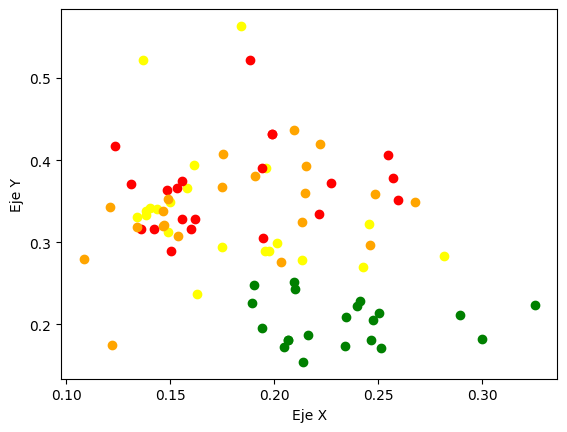

In [45]:
cutoff = 2000
cuton = 10
features = dict.fromkeys(fruit_types)
# Extracción de características
componente = 0
n_mfcc = 4
while componente < n_mfcc:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

            signal = band_pass_filter(signal, sr, cuton, cutoff)
            
            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            frames = range(mfccs.shape[1])

            t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            #feat = np.dot(mfccs[:, ((mfccs.shape[1]*3)//5 - 5) : ((mfccs.shape[1]*3)//5 + 5)], t[((len(t)*3)//5 - 5) : ((len(t)*3)//5 + 5)])/np.sum(mfccs[:, ((mfccs.shape[1]*3)//5 - 5) : ((mfccs.shape[1]*3)//5 + 5)], axis = 1)
            feat = np.dot(np.abs(mfccs), t)/np.sum(np.abs(mfccs), axis = 1)

            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    
    componente += 1


C:\Users\Juan\AppData\Local\Temp\ipykernel_6348\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


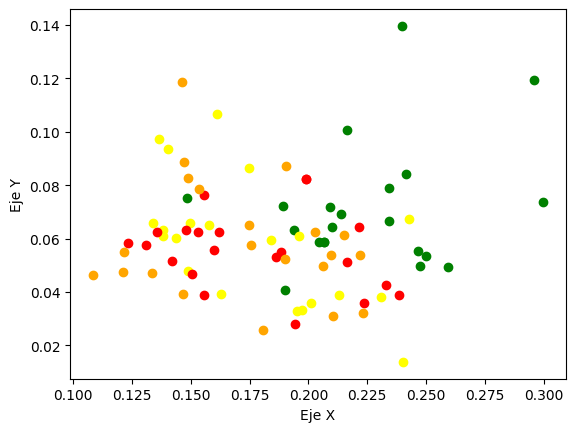

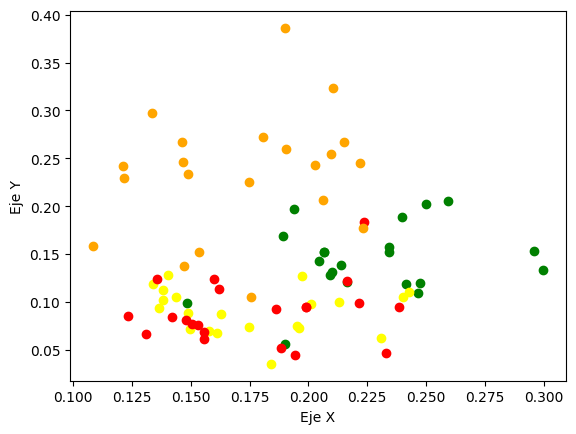

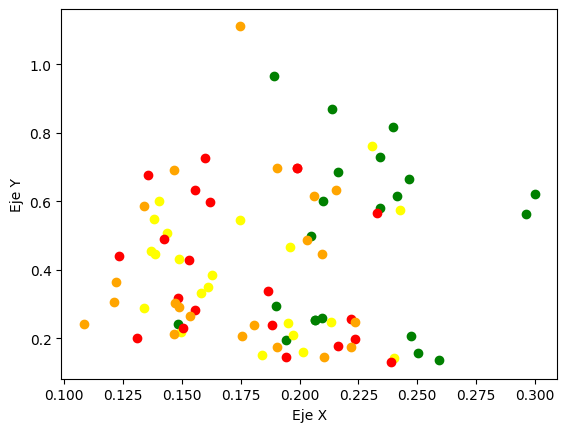

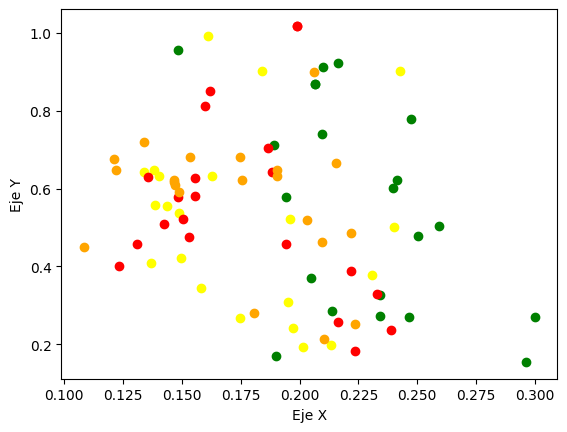

In [11]:
features = dict.fromkeys(fruit_types)
cuton =  10
cutoff = 8000
# Extracción de características
componente = 0
n_mfcc = 4
while componente < n_mfcc:
    for fruit, group in processed.items():
        features[fruit] = None
        for audio in group:
            signal, sr, duration = load_audio(audio)
            audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

            signal = band_pass_filter(signal, sr, cuton, cutoff)
            mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
            mfccs = mfccs[:, ((mfccs.shape[1]*4) // 5 - 10):((mfccs.shape[1]*4) //5 + 10)] 
            
            frames = range(mfccs.shape[1])

            t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
            #feat = np.mean(mfccs, axis=1)
            #feat = np.var(mfccs, axis=1)
            feat = np.std(np.abs(mfccs), axis=1) / np.mean(np.abs(mfccs), axis=1)
            #feat = np.max(mfccs, axis=1)
            #feat = np.min(mfccs, axis=1)

            feature = np.array([[audio_rms, feat[componente]]])
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    # Ploteo
    plot_features2d(features)
    componente += 1

In [45]:
def plot_signal(signal, duration, name):
    time_vector = np.linspace(0, duration, len(signal))
    time_vector/=time_vector[-1]
    plt.figure(figsize=(15, 5))
    
    #plot
    #librosa.display.waveshow(signal)
    
    plt.plot(time_vector, signal, linestyle='-')
    
    # extra
    plt.title(f'Señal de Audio {name} - Duración: {duration:.2f} segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.show()